# Black-Scholes: Monte Carlo pricing

In this notebook, we show we can use European options using Monte Carlo. 

## Geometric Brownian motion: simulation

Define Parameters:

<b> STEP 1. Determine the parameters required for the simulation, including: </b>

* Current stock price (S0)
* Strike price (K)
* Time to expiration (T)
* Volatility (σ)
* Risk-free interest rate (r)
* These parameters are essential inputs for the Black-Scholes formula.

<b> STEP 2. Generate Brownian Motion: </b>

Use a random number generator to simulate Brownian motion.
Brownian motion is a stochastic process that represents the continuous random movement of particles. It is characterized by its mean and variance, which are both zero.
Generate random increments of Brownian motion using the properties of normal distribution with mean 0 and variance 1.

<b> STEP 3. Calculate the drift component (μ) and diffusion component (σ) of the stock price using the Black-Scholes formulas: </b>

* Drift (μ) = (r - 0.5 * σ^2) * Δt
* Diffusion (σ) = σ * √(Δt)
* Δt represents the time step for each 

<b> STEP 4. Model the Paths of Stock Prices: </b>

The stock price paths can be simulated by using the geometric Brownian motion equation:

* exp((μ - 0.5 * σ^2) * t + σ * √(t) * Z) * S(t) = S(0)
  
In this case, Z is a random variable produced from the usual normal distribution, μ is the drift component, σ is the diffusion component, t is the time step, and S(t) represents the stock price at time t.

<b> STEP 5. Determine the Option Payoff: </b>

Determine the option payment at expiration for each simulated stock price trend.
For a call option, use Max(0, S-K).
Max(K-S, 0) is the value of a put option.
Based on the simulated stock price, this shows the option's value at expiration.

<b> STEP 6. Payoff Discounted to Present Value: </b>

Using the risk-free interest rate, discount the option payment to its current value:
* Payoff * exp(-r * T) equals PV.
where T is the period until expiry, r is the risk-free interest rate, Payoff is the option payoff at expiration, and PV is the present value of the option payoff.

<b> STEP 7. Rerun the simulation: </b>

To get a distribution of option values, repeat steps 2 through 6 a lot of times.
The choice value is estimated more accurately the more iterations are carried out.

<b> STEP 8. Determine the Option Price: </b>

To estimate the option price, take the mean of all discounted option payoffs that you were able to acquire from the simulations.
The Black-Scholes model's estimate of the option's fair value is represented by this price.




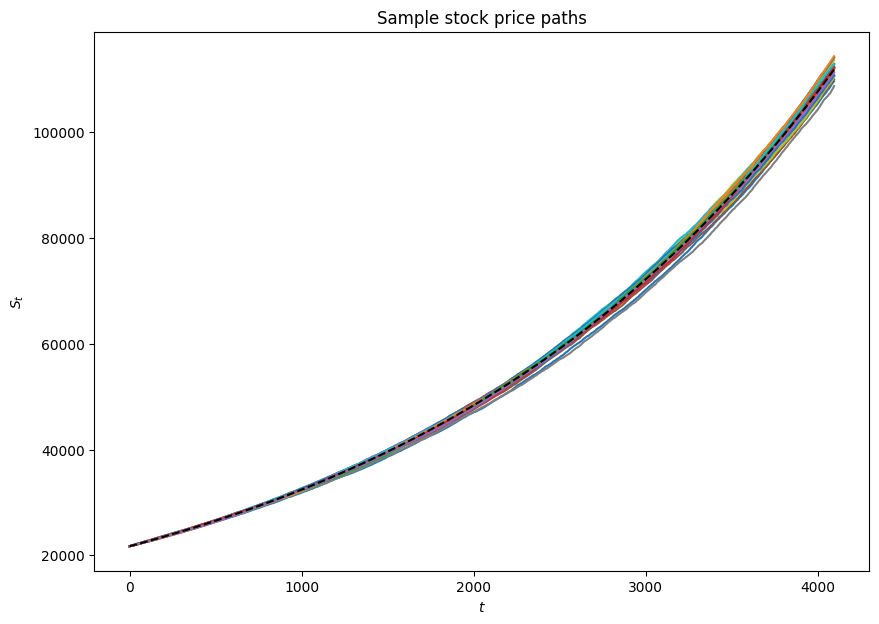

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st

# # Parameters
mean = 0.0004        # mean
sigma = 0.0002     # standard deviation
npaths = 50000  # number of paths
nsteps = 1000    # number of time steps
npathsplot = 25 # number of paths ploted
T = 2**12           # time horizon
dt = T/nsteps   # time step
S0 = 21730.4        # Initial stock price

t = np.linspace(0, T, nsteps+1) # time grid

# Compute the increments of the arithmetic brownian motion X = log(S/S0)
dX = (mean - 0.5*sigma**2)*dt + sigma*np.sqrt(dt)*np.random.normal(size=(npaths, nsteps))

# Accumulate the increments starting at 0
X = np.concatenate((np.zeros((npaths, 1)), np.cumsum(dX, axis=1)), axis=1)

# Transform to geometric Brownian motion
S = S0*np.exp(X)

# Plot potential stock price paths
fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111)
for i in range(0, npaths, round(npaths/npathsplot)):
    ax.plot(t, S[i,:])
ax.plot(t, np.mean(S, axis=0), 'k--') # mean path
ax.set_title('Sample stock price paths')
ax.set_xlabel(r'$t$')
ax.set_ylabel(r'$S_t$');

Now plot the distribution of the stock price based on maturity and fitting a log-normal distribution curve on top of it.

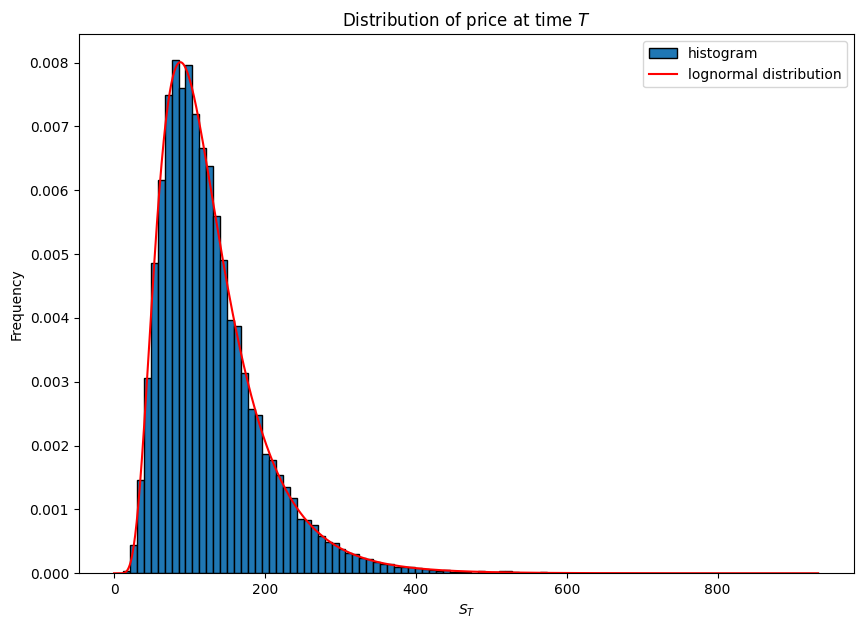

In [2]:
# Plot the distribution of the stock price at maturity
fig = plt.figure(figsize=(10, 7)) 
ax = fig.add_subplot(111)
ax.hist(S[:,-1], 100, density=True, ec='k', label='histogram')
ax.set_title(r'Distribution of price at time $T$')
ax.set_xlabel(r'$S_T$')
ax.set_ylabel('Frequency')

# Fit a log-normal distribution curve
S_grid = range(int(S[:,-1].max())+1)
params = st.lognorm.fit(S[:,-1], scale=100)
pdf = st.lognorm.pdf(S_grid, *params)
ax.plot(S_grid, pdf, 'r', label='lognormal distribution')
ax.legend();

The pricing of an option entails calculating the present value of the anticipated payoff under a risk-neutral framework. This can be achieved by conducting numerous simulations of potential price paths and then averaging the discounted payoff for each simulated path. Notably, since the formula is entirely deterministic, there's no requirement to generate the entire path, especially for options dependent on path progression. Instead, solely simulating the terminal value suffices. To determine the risk-neutral drift, we substitute $\mu$ with $r - q$ ($r$ representing the risk-free rate and $q$ denoting the dividend rate).

Let's establish some parameters and proceed with pricing the options.

In [12]:
# Market params
T = 128.0/365.0       # maturity
S0 = 21730     # spot price
K = 22200    # strike price
r = 0.05   # risk-free interest rate
q = 0.0   # dividend rate

#model  params
sigma = 0.02 # volatility

# risk-neutral measure
muRN = r-q-0.5*sigma**2 # drift

# Monte Carlo parameters; npaths = nblocks*nsample
nblocks = 30000 # no. of blocks
nsample = 10000 # no. of samples per block

# initialize arrays
Vc_list = np.zeros(nblocks) # call array
Vp_list = np.zeros(nblocks) # put array

# monte carlo
for i in range(nblocks):
    X = muRN*T + sigma*np.sqrt(T) * np.random.normal(size=(1, nsample))
    S = S0*np.exp(X)
    Vc_list[i] = np.exp(-r*T)*np.mean(np.maximum(S - K, 0))
    Vp_list[i] = np.exp(-r*T)*np.mean(np.maximum(K - S, 0))

# final call and put values
Vc = np.mean(Vc_list)
Vp = np.mean(Vp_list)

print('The value of the call is: ' + str(round(Vc, 5)))
print('The value of the put is:  ' + str(round(Vp, 5)))

The value of the call is: 66.22856
The value of the put is:  150.36947


The accuracy of the Monte Carlo simulation can be improved by increasing the number of paths (```nblocks``` $\times$ ```nsample```) or by using variance reduction techniques (e.g., antithetic variates).